In [5]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 25.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 57.0 MB/s eta 0:00:00a 0:00:01


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

import warnings; warnings.filterwarnings("ignore")

In [12]:
!pip install opencv-python

In [13]:
#Load a small subset of the DIV2K dataset
def load_images(folder, target_size=(256, 256), sample_size = 10):
    images = []
    filenames = os.listdir(folder)[:sample_size]
    for filename in filenames:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            images.append(img)
    return np.array(images)

# Simulate low-resolution images
def downscale_images(images, scale=2):
    low_res = []
    for img in images:
        lr = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale))
        lr = cv2.resize(lr, (img.shape[1], img.shape[0]))
        low_res.append(lr)
    return np.array(low_res)

# Define SRCNN Model
def build_srcnn():
    model = Sequential([
        Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(256, 256, 3)),
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())
    return model

In [16]:
# Load small subset of DIV2K dataset
hr_train_images  = load_images("/Users/snehabejugam/Downloads/div2k/DIV2K_train_HR/DIV2K_train_HR", sample_size=800)
lr_train_images  = downscale_images(hr_train_images)

hr_val_images = load_images("/Users/snehabejugam/Downloads/div2k/DIV2K_valid_HR/DIV2K_valid_HR", sample_size=100)
lr_val_images = downscale_images(hr_val_images)

# Normalize images
hr_train_images, lr_train_images = hr_train_images / 255.0, lr_train_images / 255.0
hr_val_images, lr_val_images = hr_val_images / 255.0, lr_val_images / 255.0

In [17]:
# Train SRCNN
model = build_srcnn()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


model.fit(
    lr_train_images, hr_train_images,
    validation_data=(lr_val_images, hr_val_images),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - loss: 0.1415 - val_loss: 0.0198
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - loss: 0.0175 - val_loss: 0.0135
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - loss: 0.0117 - val_loss: 0.0099
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.0089 - val_loss: 0.0087
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - loss: 0.0072 - val_loss: 0.0073
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - loss: 0.0071 - val_loss: 0.0073
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - loss: 0.0071 - val_loss: 0.0070
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - loss: 0.0067 - val_loss: 0.0069
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 410s 8s/step - loss: 0.0066 - val_loss: 0.0068
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.0

In [20]:
val_preds = model.predict(lr_val_images)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


In [22]:
psnr_value = psnr(hr_val_images[0], val_preds[0])
ssim_value = ssim(hr_val_images[0], val_preds[0], win_size=3, channel_axis=-1, data_range=1.0)

print(f"PSNR: {psnr_value}, SSIM: {ssim_value}")

PSNR: 22.833779762370874, SSIM: 0.6469033794883662


In [24]:
def visualized_diff(i):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(lr_val_images[i])
    axes[0].set_title("Low-Res")
    
    axes[1].imshow(val_preds[i])
    axes[1].set_title("Super-Resolved")
    
    axes[2].imshow(hr_val_images[i])
    axes[2].set_title("High-Res")
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.115943216..1.1318272].


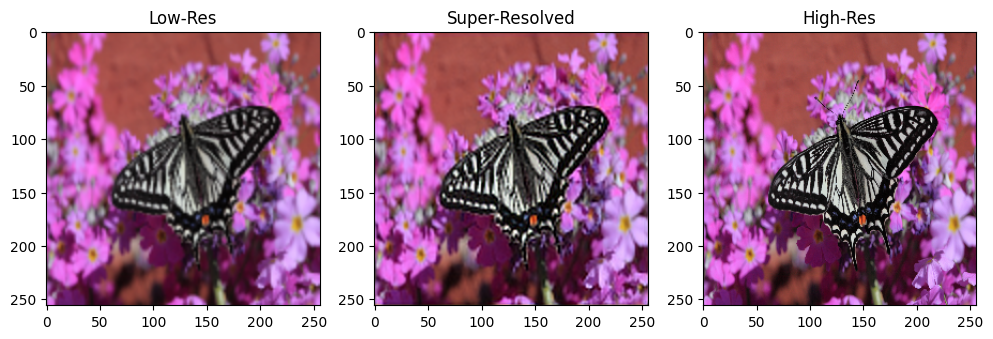

In [26]:
visualized_diff(30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14426698..1.1071268].


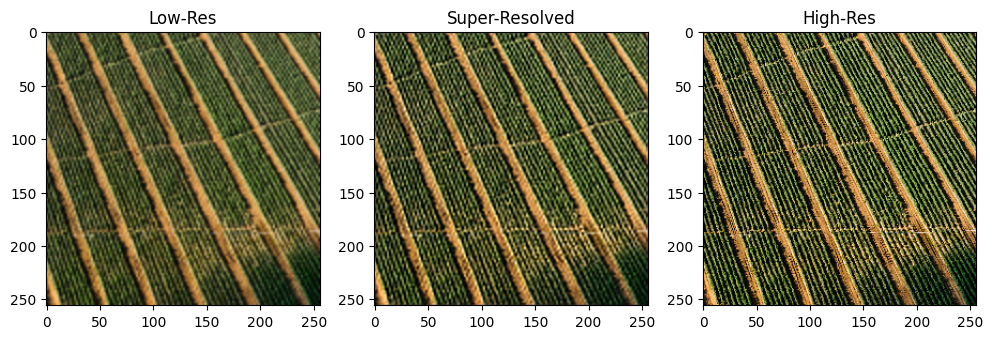

In [28]:
visualized_diff(32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13497822..1.1056608].


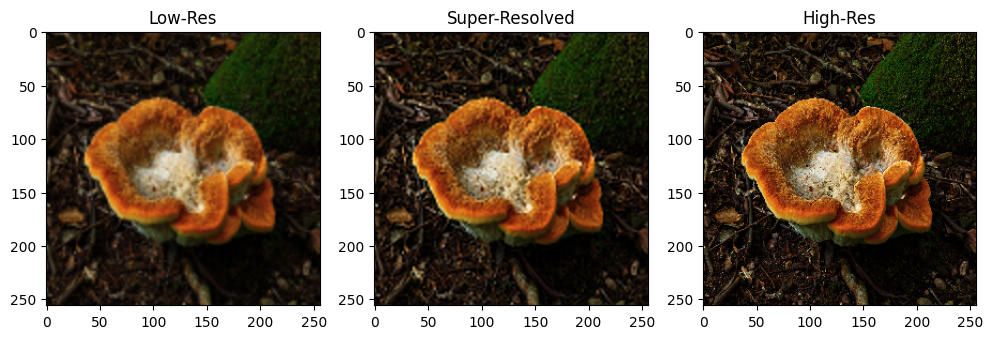

In [30]:
visualized_diff(80)